# Time Travel in Reinforcement Learning

## PFRL version - PPO (normal + recurrent)

In [1]:
import pfrl
import torch
import torch.nn
import gym
import numpy

import gym_minigrid
import gym_minigrid.wrappers

import matplotlib.pyplot as plt

Prepare modified MiniGrid environment with time travel capabilities.

In [2]:
env = gym.make('MiniGrid-DoorKey-8x8-v0')
env = gym_minigrid.wrappers.OneHotPartialObsWrapper(env) # make every tile one-hot encoded
env = gym_minigrid.wrappers.ImgObsWrapper(env) # keep image part, ditch 'mission' field

print('observation space (shape):', env.observation_space.shape)
print('action space (shape):', env.action_space)

obs = env.reset()

action = env.action_space.sample()
obs, r, done, info = env.step(action)
print('reward:', r)
print('done:', done)
print('info:', info)

# Uncomment to open a GUI window rendering the current state of the environment
# env.render()

observation space (shape): (7, 7, 20)
action space (shape): Discrete(10)
reward: 0
done: False
info: {}


Take a look at the environment

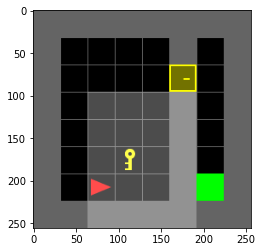

In [3]:
img = env.render("rgb_array")
plt.imshow(img)

In [4]:
obs_size = env.observation_space.low.size
n_actions = env.action_space.n

Create approximators - one normal feedforward network and one recurrent. Each apprximator is a policy-value network. For agent from PFRL library, recurrent network must be a cubclass of `pfrl.nn.Recurrent`.

In [5]:
pv_network = torch.nn.Sequential(
    torch.nn.Linear(obs_size, 128),
    torch.nn.Tanh(),
    torch.nn.Linear(128, 128),
    torch.nn.Tanh(),
    pfrl.nn.Branched(
        torch.nn.Sequential(
            torch.nn.Linear(128, n_actions),
            pfrl.policies.SoftmaxCategoricalHead()
        ),
        torch.nn.Sequential(
            torch.nn.Linear(128, 1)
        )
    )
)

In [6]:
pv_network_rec = pfrl.nn.recurrent_sequential.RecurrentSequential(
    torch.nn.Linear(obs_size, 128),
    torch.nn.Tanh(),
    torch.nn.LSTM(128, 128),
    pfrl.nn.Branched(
        torch.nn.Sequential(
            torch.nn.Linear(128, n_actions),
            pfrl.policies.SoftmaxCategoricalHead()
        ),
        torch.nn.Sequential(
            torch.nn.Linear(128, 1)
        )
    )
)

Create an optimizer.

In [7]:
optimizer = torch.optim.Adam(pv_network.parameters(), eps=1e-5)

In [8]:
optimizer_rec = torch.optim.Adam(pv_network_rec.parameters(), eps=1e-5)

Prepare hyperparameters, exploration-exploitation policy, feature extractor and set up some settings.

In [9]:
# Set the discount factor that discounts future rewards.
gamma = 0.99

# Use epsilon-greedy for exploration
explorer = pfrl.explorers.ConstantEpsilonGreedy(
    epsilon=0.3, random_action_func=env.action_space.sample
)

# Observations from MiniGrid are numpy.uint8;
# PyTorch only accepts numpy.float32 by default;
# Here we define feature extractor phi that simply converts number types.
phi = lambda x: x.astype(numpy.float32, copy=False)

# Set the device to use CPU only.
gpu = -1

Prepare PPO agents 

In [10]:
agent = pfrl.agents.PPO(
    pv_network,
    optimizer,
    recurrent=False,
    phi=phi,
    gamma=gamma
)

In [11]:
agent_rec = pfrl.agents.PPO(
    pv_network_rec,
    optimizer_rec,
    recurrent=True,
    phi=phi,
    gamma=gamma
)

Train normal agent

In [12]:
n_episodes = 3000
max_episode_len = 200
for i in range(1, n_episodes + 1):
    obs = env.reset()
    obs = obs.flatten()
    R = 0  # return (sum of rewards)
    t = 0  # time step
    while True:
        # Uncomment to watch the behavior in a GUI window
        # env.render()
        action = agent.act(obs)
        obs, reward, done, _ = env.step(action)
        obs = obs.flatten()
        R += reward
        t += 1
        reset = t == max_episode_len
        agent.observe(obs, reward, done, reset)
        if done or reset:
            break
    if i % 100 == 0:
        print('episode:', i, 'R:', R)
    if i % 500 == 0:
        print('statistics:', agent.get_statistics())
print('Finished.')

episode: 100 R: 0
episode: 200 R: 0
episode: 300 R: 0
episode: 400 R: 0
episode: 500 R: 0
statistics: [('average_value', 0.004074986), ('average_entropy', 1.9546077), ('average_value_loss', 3.6266228812564803e-06), ('average_policy_loss', -0.05982794217765331), ('n_updates', 15360), ('explained_variance', -1.075084062759514)]
episode: 600 R: 0
episode: 700 R: 0
episode: 800 R: 0
episode: 900 R: 0
episode: 1000 R: 0
statistics: [('average_value', -0.0023889488), ('average_entropy', 1.8686401), ('average_value_loss', 2.249460107464074e-06), ('average_policy_loss', -0.05502518525347114), ('n_updates', 31040), ('explained_variance', -0.9349118825737399)]
episode: 1100 R: 0
episode: 1200 R: 0
episode: 1300 R: 0
episode: 1400 R: 0
episode: 1500 R: 0
statistics: [('average_value', -0.004611305), ('average_entropy', 1.764808), ('average_value_loss', 2.5571212800059583e-05), ('average_policy_loss', -0.06970836385153234), ('n_updates', 46720), ('explained_variance', -0.4193612595254088)]
episode

Test normal agent (no exploration)

In [14]:
with agent.eval_mode():
    for i in range(10):
        obs = env.reset()
        obs = obs.flatten()
        R = 0
        t = 0
        while True:
            # Uncomment to watch the behavior in a GUI window
            # env.render()
            action = agent.act(obs)
            obs, r, done, _ = env.step(action)
            obs = obs.flatten()
            R += r
            t += 1
            reset = t == 200
            agent.observe(obs, r, done, reset)
            if done or reset:
                break
        print('evaluation episode:', i, 'R:', R)

evaluation episode: 0 R: 0
evaluation episode: 1 R: 0
evaluation episode: 2 R: 0
evaluation episode: 3 R: 0
evaluation episode: 4 R: 0
evaluation episode: 5 R: 0
evaluation episode: 6 R: 0
evaluation episode: 7 R: 0
evaluation episode: 8 R: 0
evaluation episode: 9 R: 0


Train agent with recurrent policy-value network

In [15]:
n_episodes = 10000
max_episode_len = 200
for i in range(1, n_episodes + 1):
    obs = env.reset()
    obs = obs.flatten()
    R = 0  # return (sum of rewards)
    t = 0  # time step
    while True:
        # env.render()
        action = agent_rec.act(obs)
        obs, reward, done, _ = env.step(action)
        obs = obs.flatten()
        R += reward
        t += 1
        reset = t == max_episode_len
        agent_rec.observe(obs, reward, done, reset)
        if done or reset:
            break
    if i % 100 == 0:
        print('episode:', i, 'R:', R)
    if i % 1000 == 0:
        print('statistics:', agent_rec.get_statistics())
print('Finished.')

episode: 100 R: 0
episode: 200 R: 0
episode: 300 R: 0
episode: 400 R: 0
episode: 500 R: 0
episode: 600 R: 0
episode: 700 R: 0
episode: 800 R: 0
episode: 900 R: 0
episode: 1000 R: 0
statistics: [('average_value', 0.025559127), ('average_entropy', 1.7982376), ('average_value_loss', 0.00020771621901076288), ('average_policy_loss', -0.09138007847126574), ('n_updates', 31040), ('explained_variance', -2.6402331555940086)]
episode: 1100 R: 0
episode: 1200 R: 0
episode: 1300 R: 0
episode: 1400 R: 0
episode: 1500 R: 0
episode: 1600 R: 0
episode: 1700 R: 0
episode: 1800 R: 0
episode: 1900 R: 0
episode: 2000 R: 0
statistics: [('average_value', 0.003238093), ('average_entropy', 1.715303), ('average_value_loss', 2.4635282047711372e-05), ('average_policy_loss', -0.11068434710614383), ('n_updates', 62400), ('explained_variance', -0.23267617045452083)]
episode: 2100 R: 0


KeyboardInterrupt: 

Test recurrent PPO agent

In [16]:
with agent_rec.eval_mode():
    for i in range(10):
        obs = env.reset()
        obs = obs.flatten()
        R = 0
        t = 0
        while True:
            # Uncomment to watch the behavior in a GUI window
            # env.render()
            action = agent_rec.act(obs)
            obs, r, done, _ = env.step(action)
            obs = obs.flatten()
            R += r
            t += 1
            reset = t == 200
            agent_rec.observe(obs, r, done, reset)
            if done or reset:
                break
        print('evaluation episode:', i, 'R:', R)

evaluation episode: 0 R: 0
evaluation episode: 1 R: 0
evaluation episode: 2 R: 0
evaluation episode: 3 R: 0
evaluation episode: 4 R: 0
evaluation episode: 5 R: 0
evaluation episode: 6 R: 0
evaluation episode: 7 R: 0
evaluation episode: 8 R: 0
evaluation episode: 9 R: 0


Visualize

c:\users\saveliy\projects\rl\gym-minigrid\gym_minigrid\window.py:26: MatplotlibDeprecationWarning: 
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.
  self.fig.canvas.set_window_title(title)


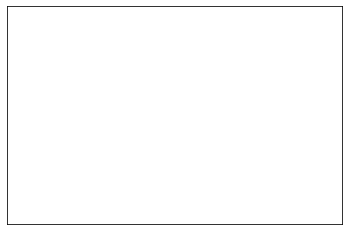

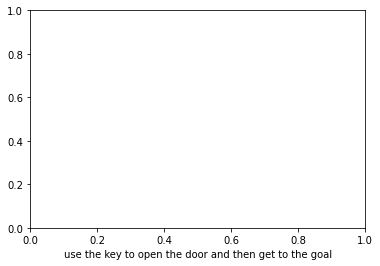

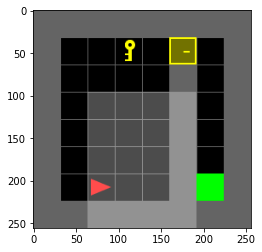

In [17]:
obs = env.reset()
obs = obs.flatten()
img = env.render()
plt.imshow(img)

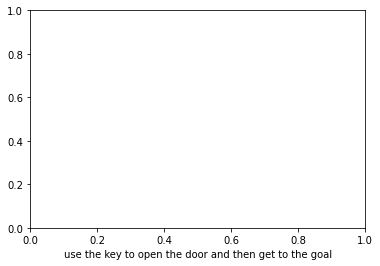

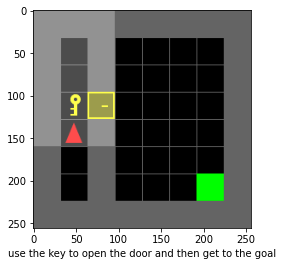

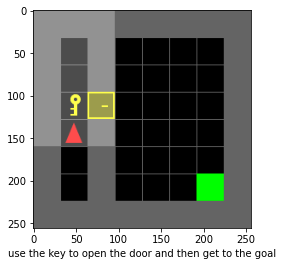

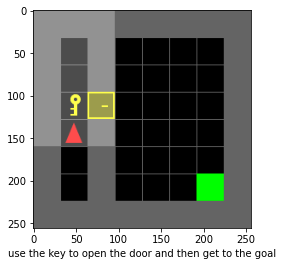

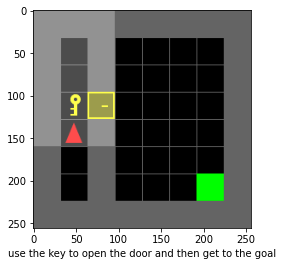

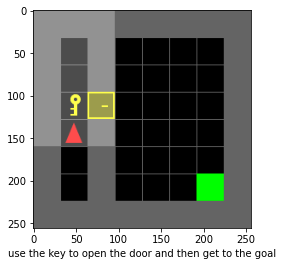

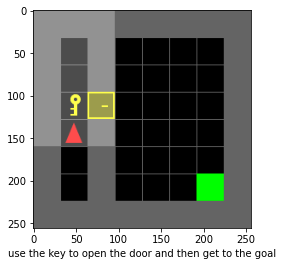

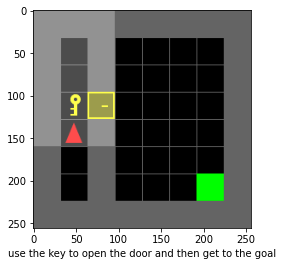

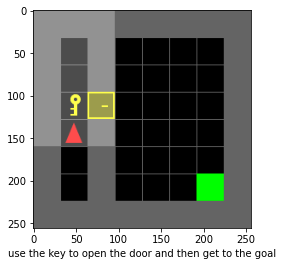

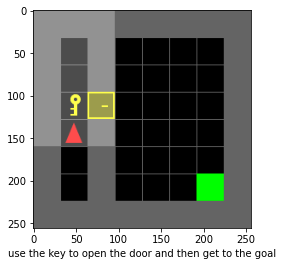

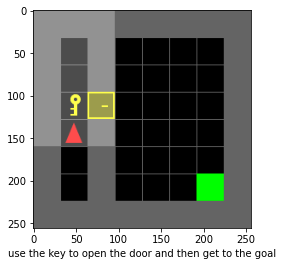

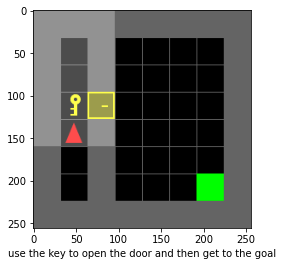

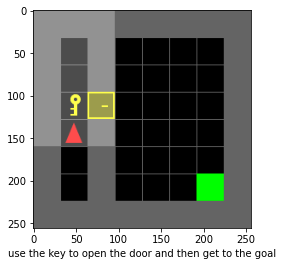

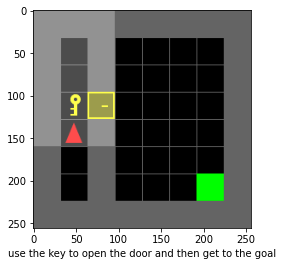

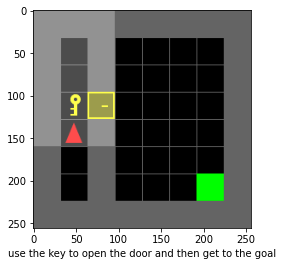

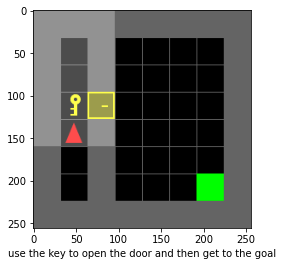

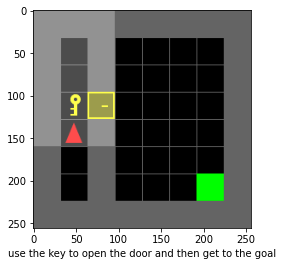

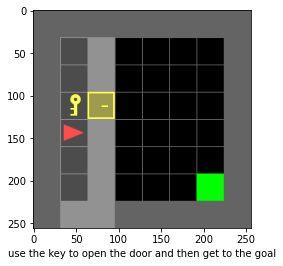

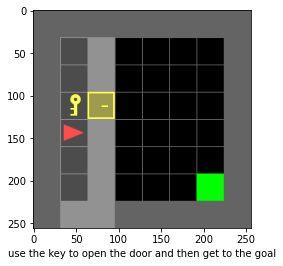

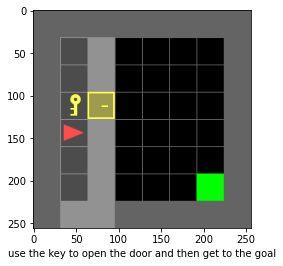

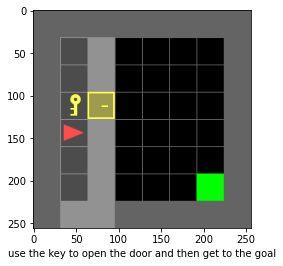

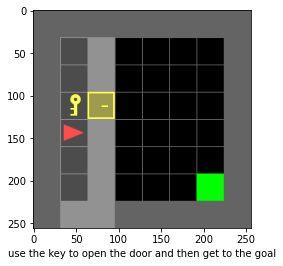

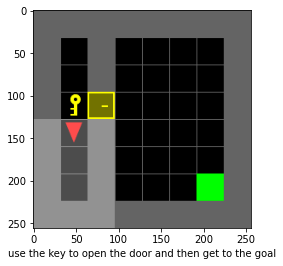

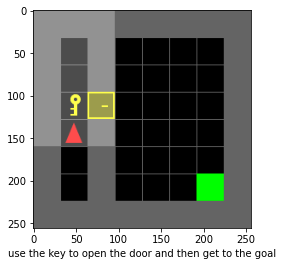

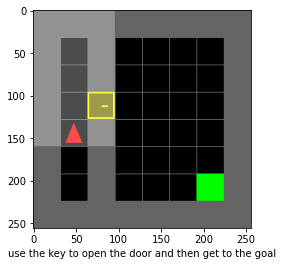

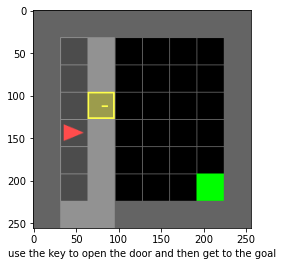

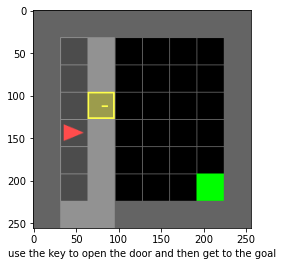

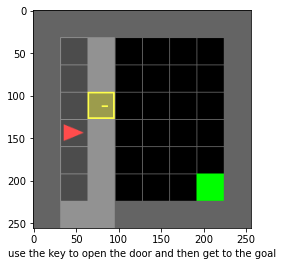

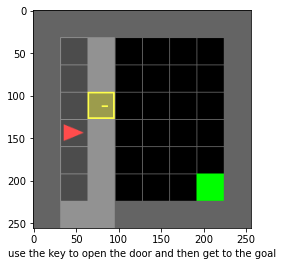

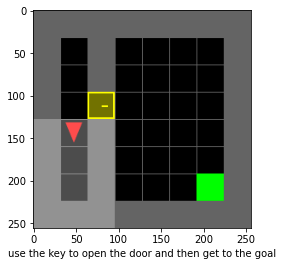

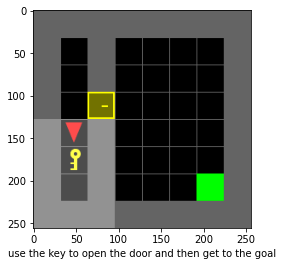

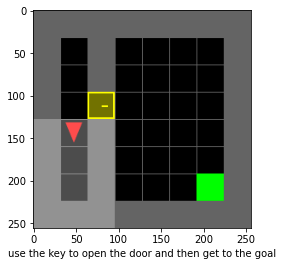

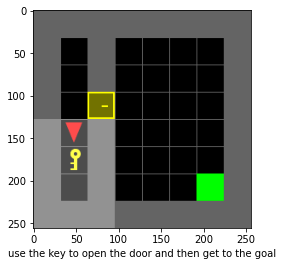

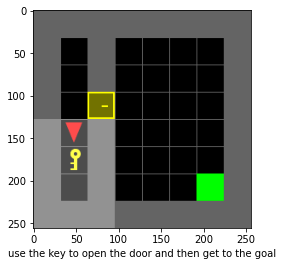

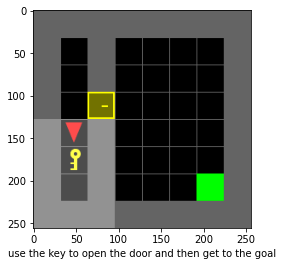

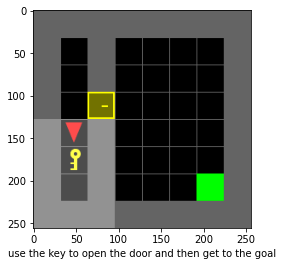

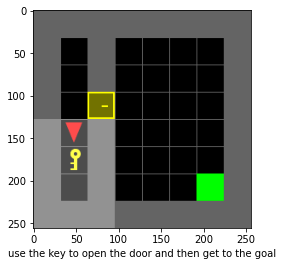

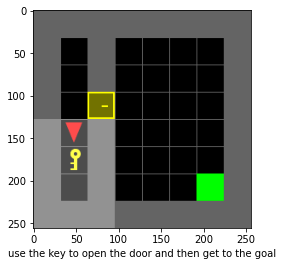

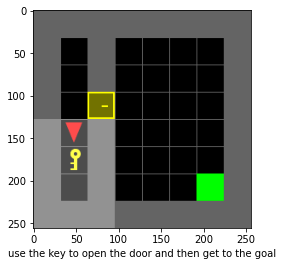

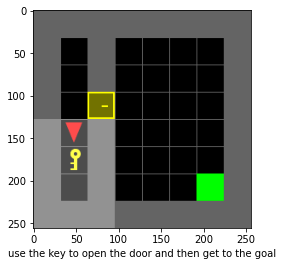

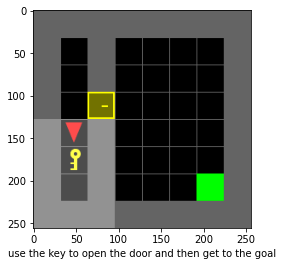

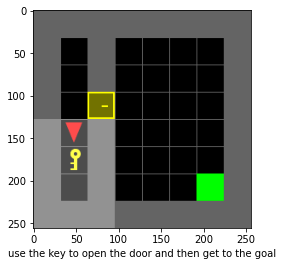

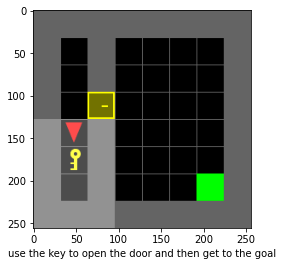

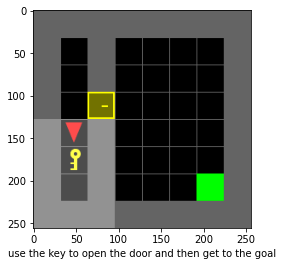

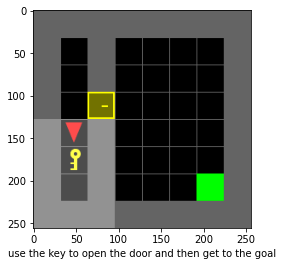

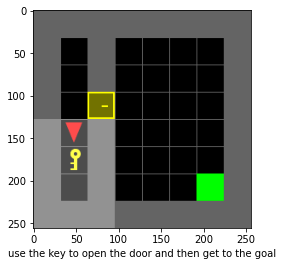

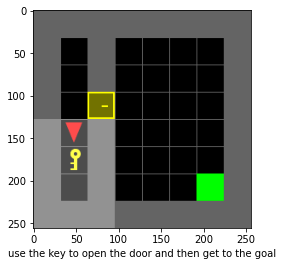

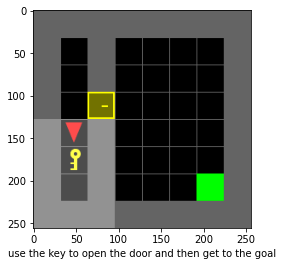

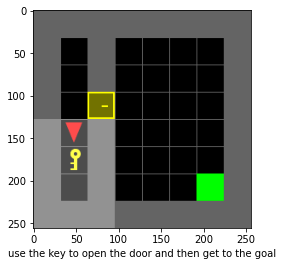

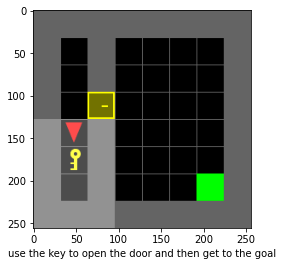

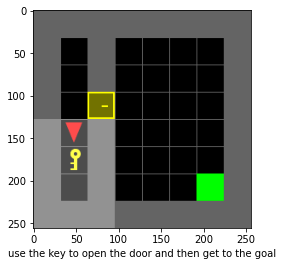

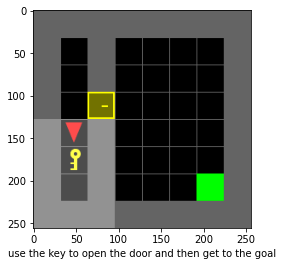

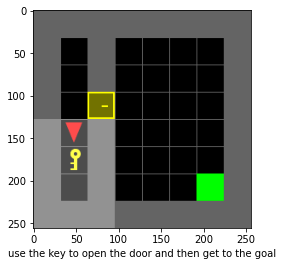

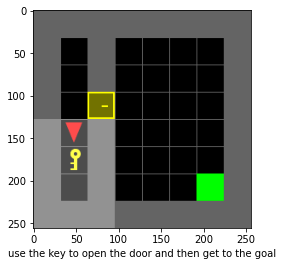

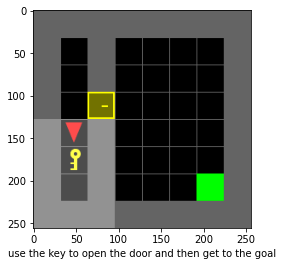

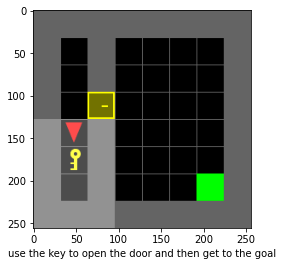

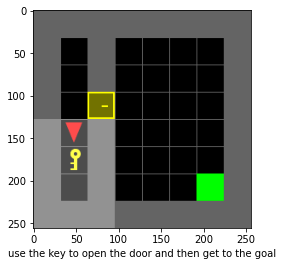

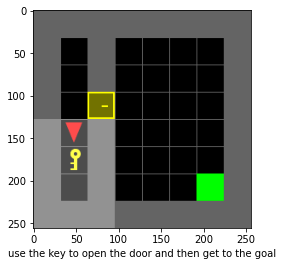

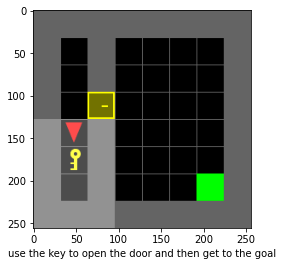

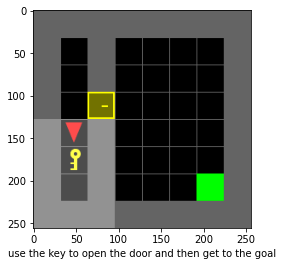

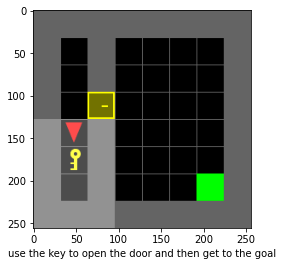

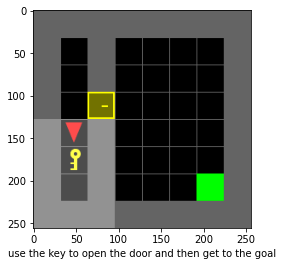

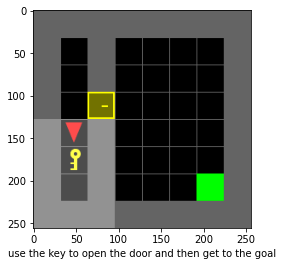

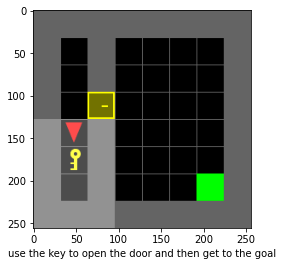

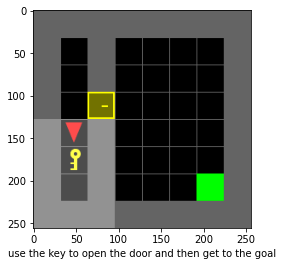

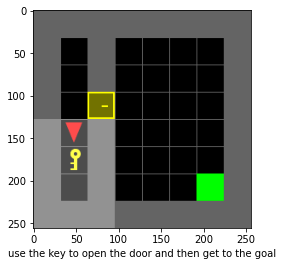

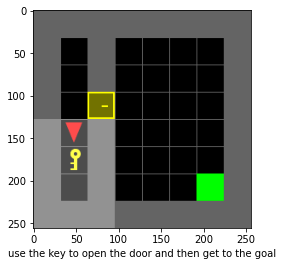

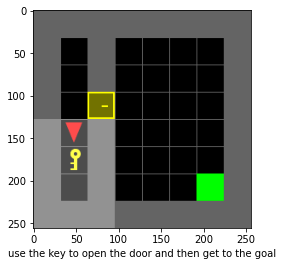

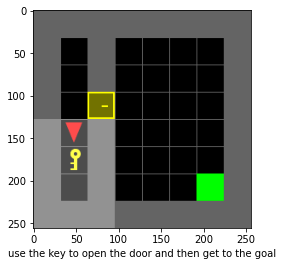

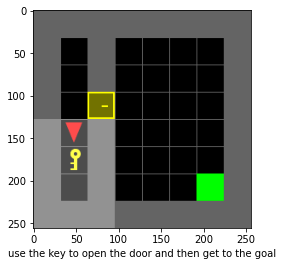

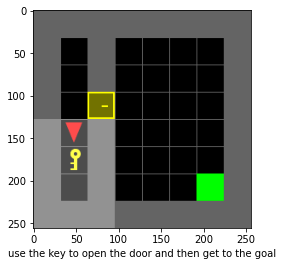

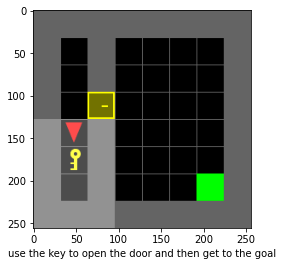

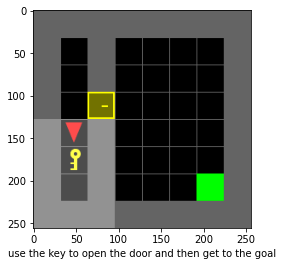

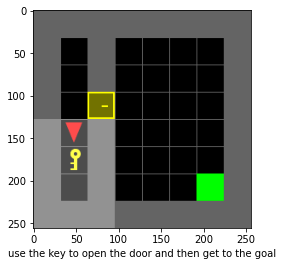

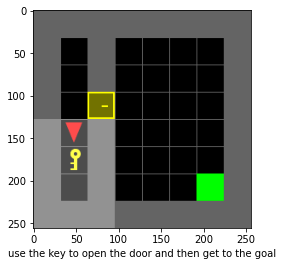

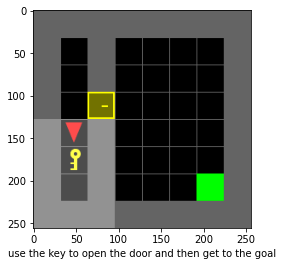

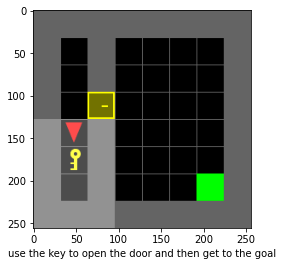

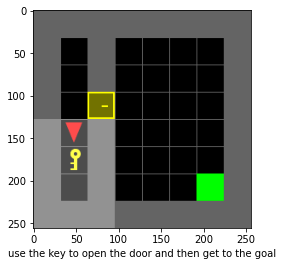

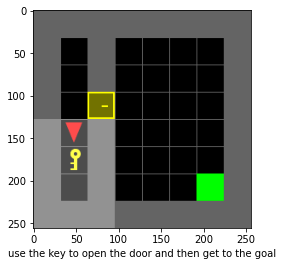

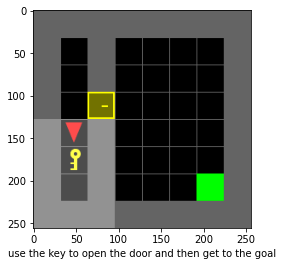

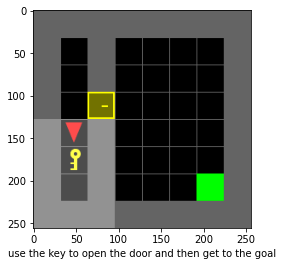

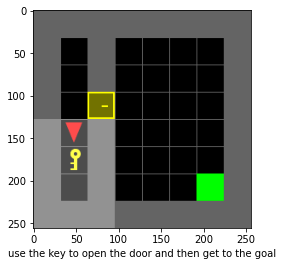

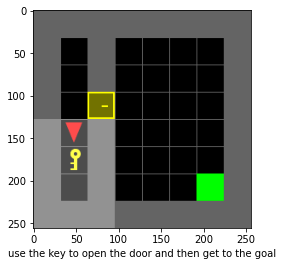

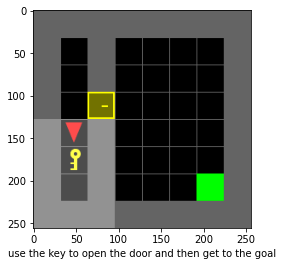

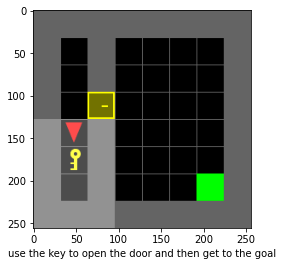

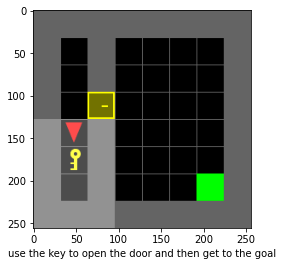

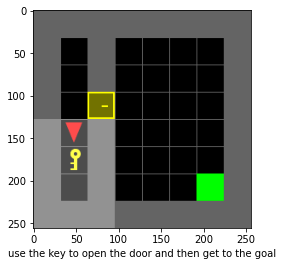

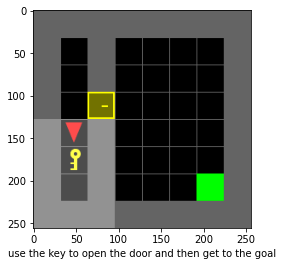

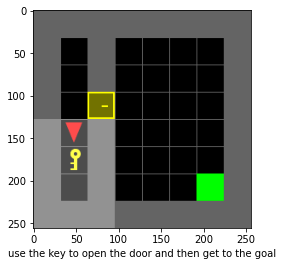

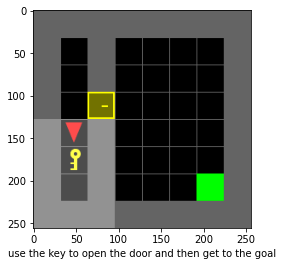

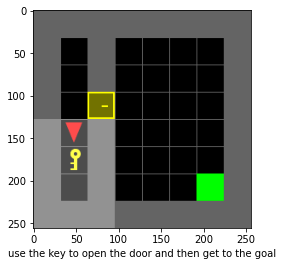

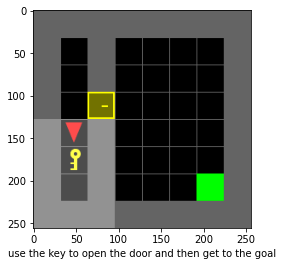

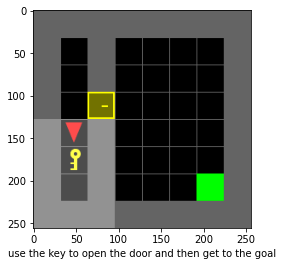

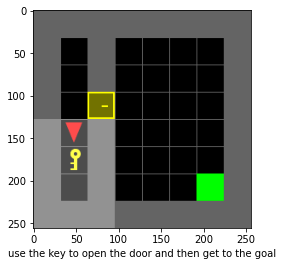

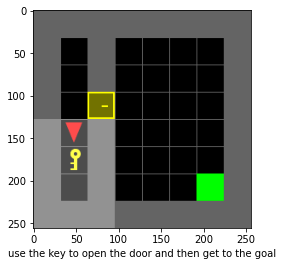

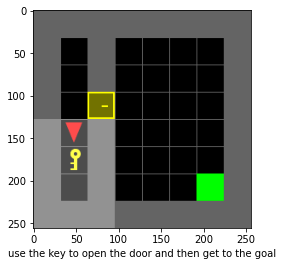

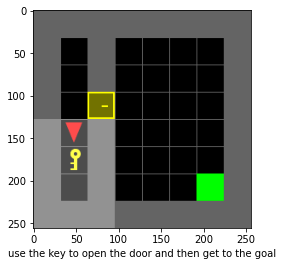

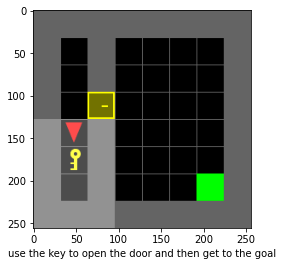

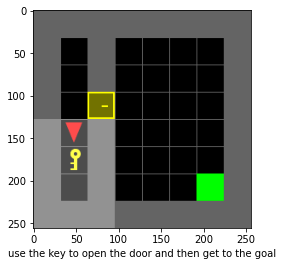

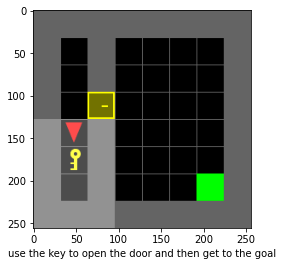

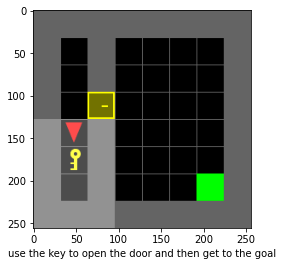

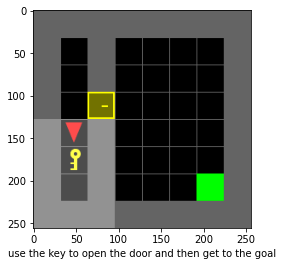

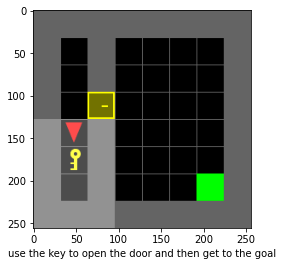

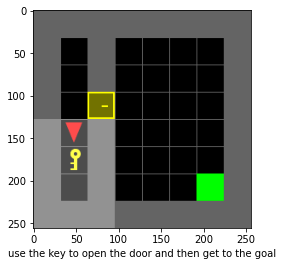

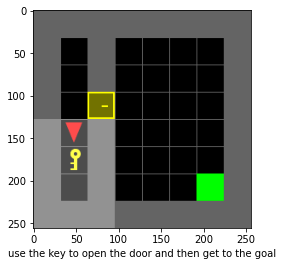

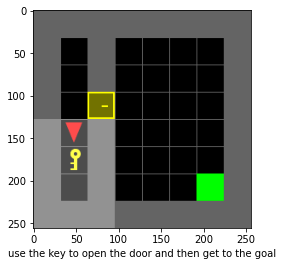

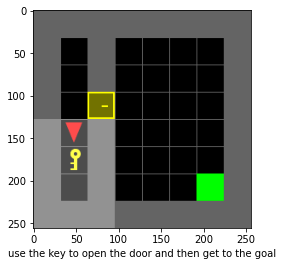

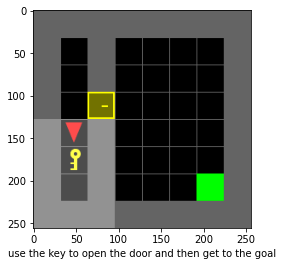

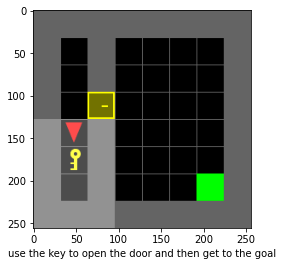

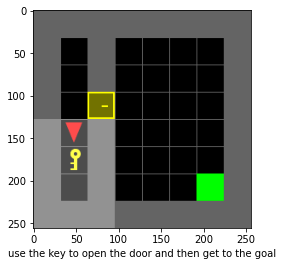

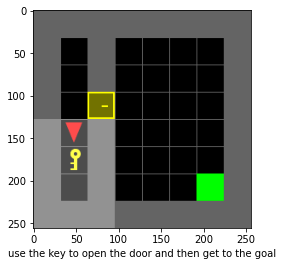

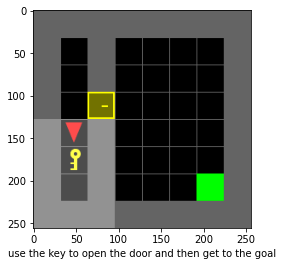

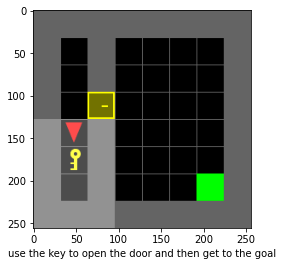

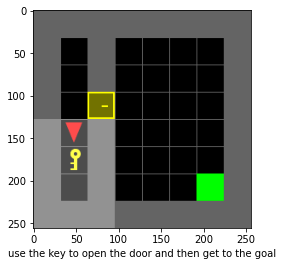

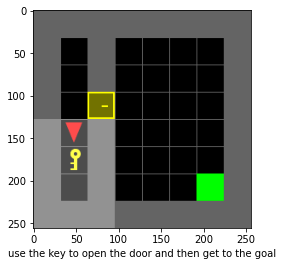

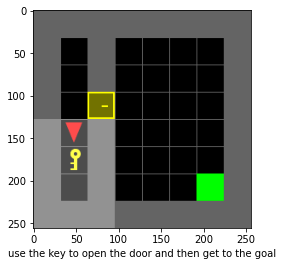

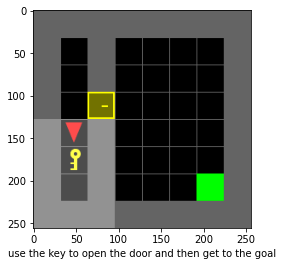

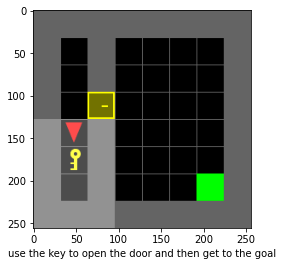

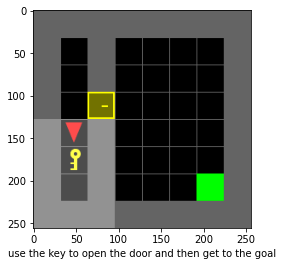

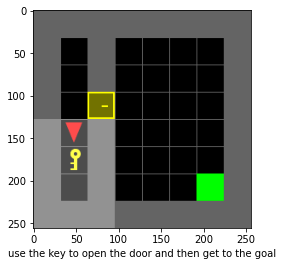

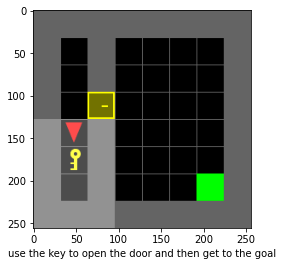

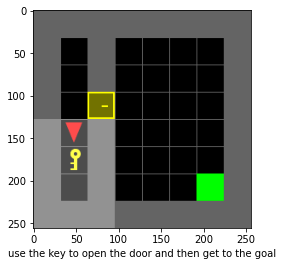

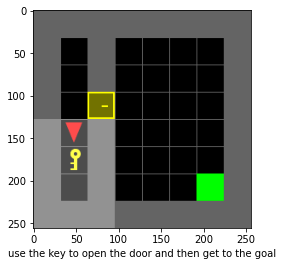

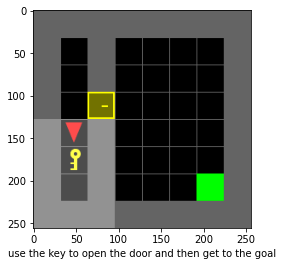

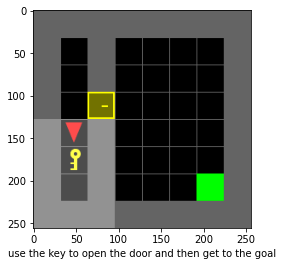

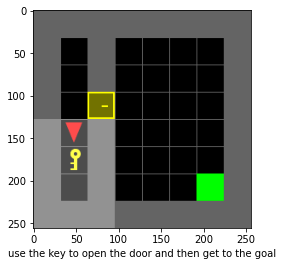

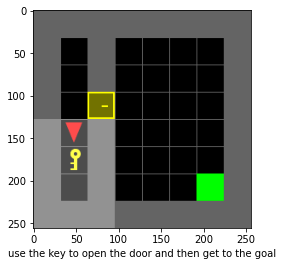

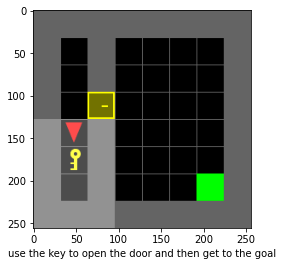

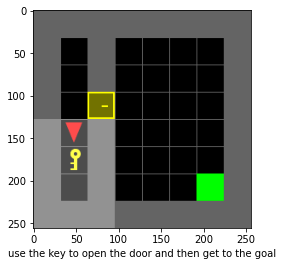

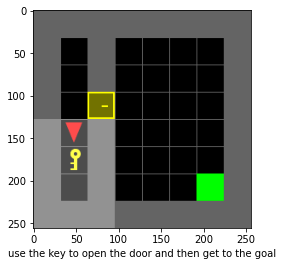

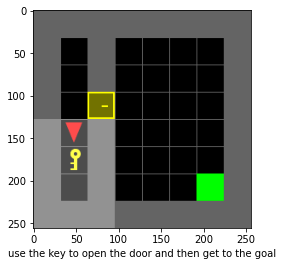

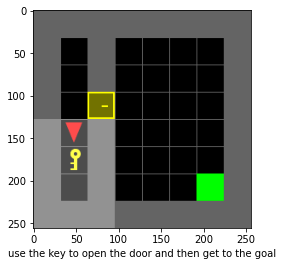

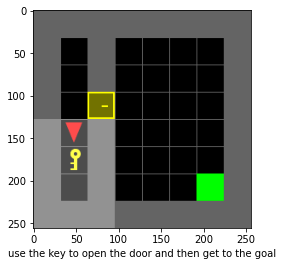

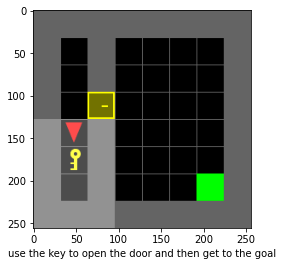

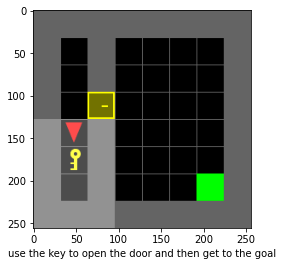

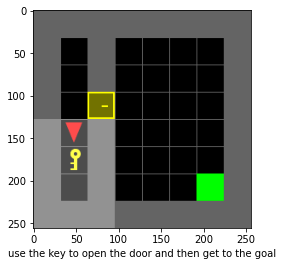

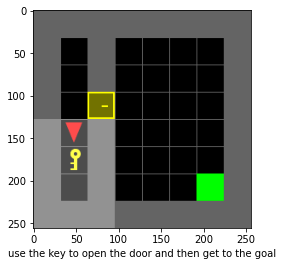

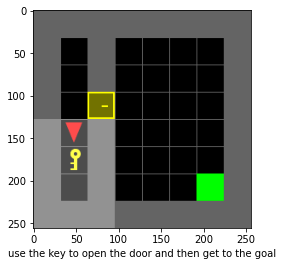

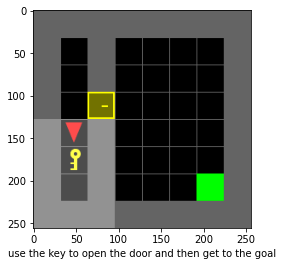

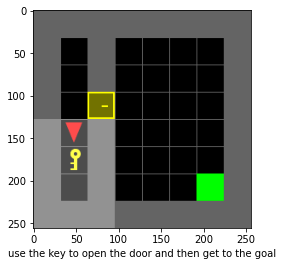

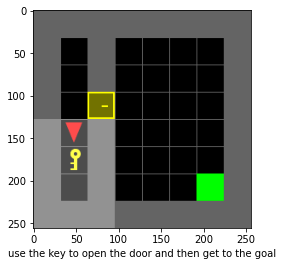

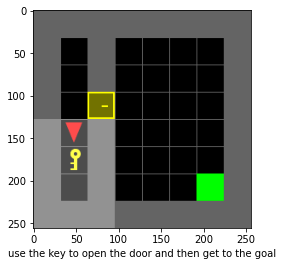

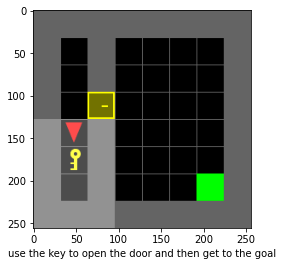

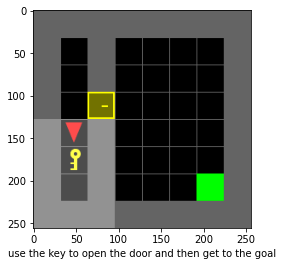

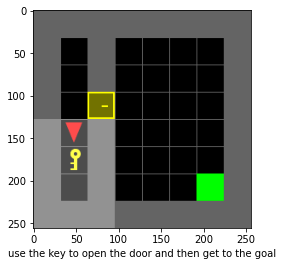

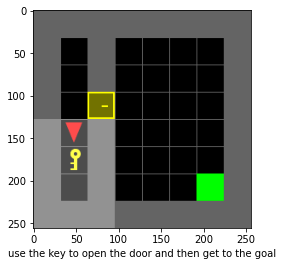

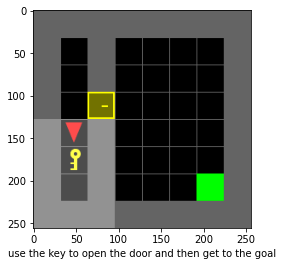

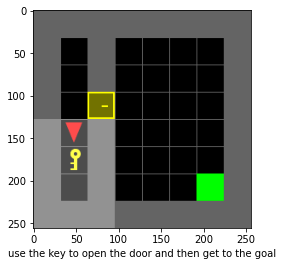

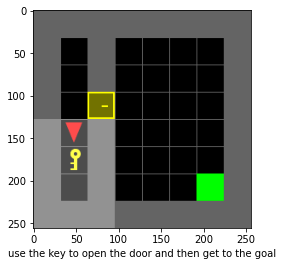

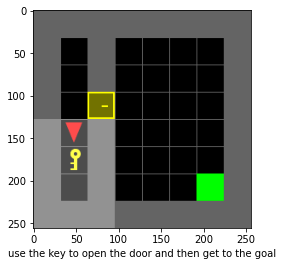

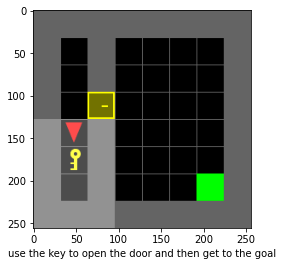

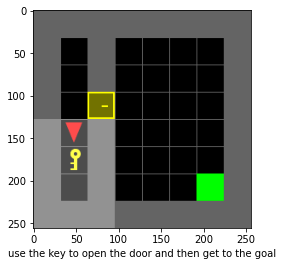

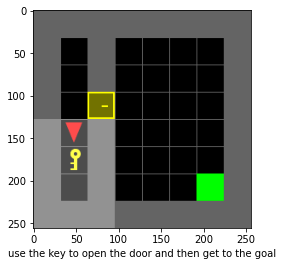

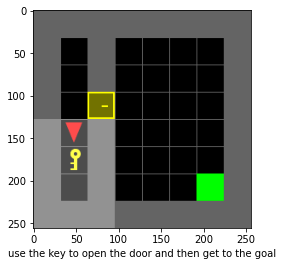

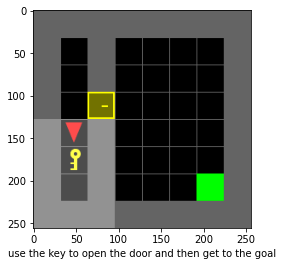

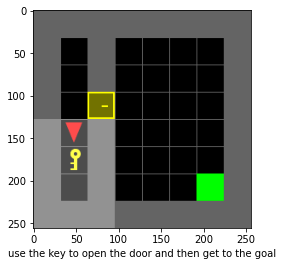

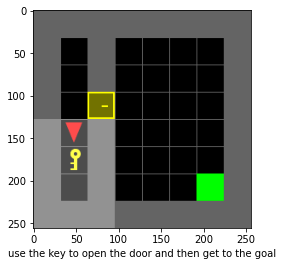

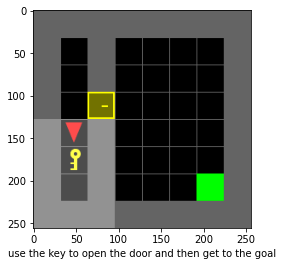

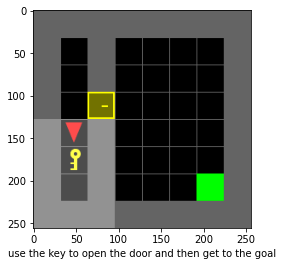

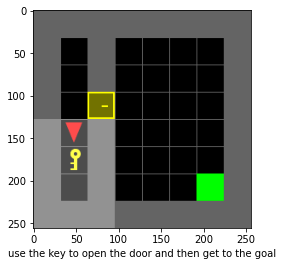

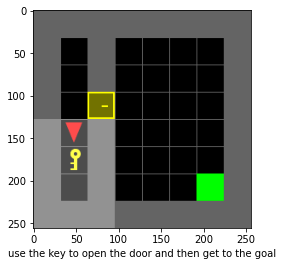

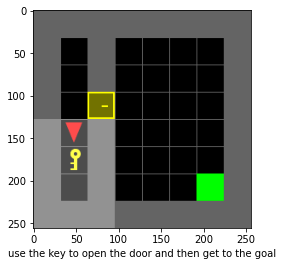

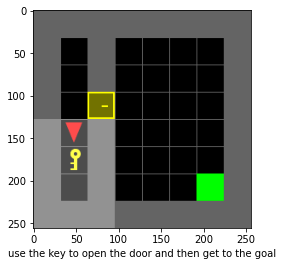

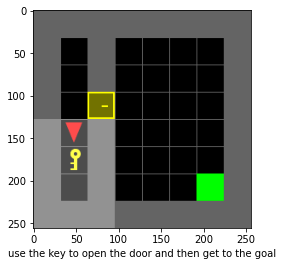

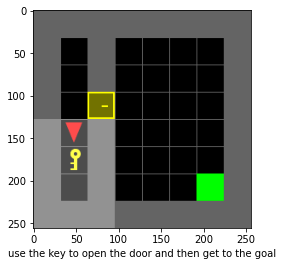

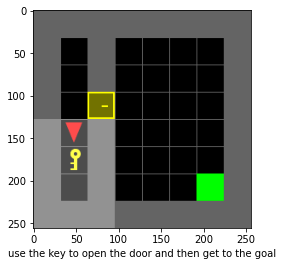

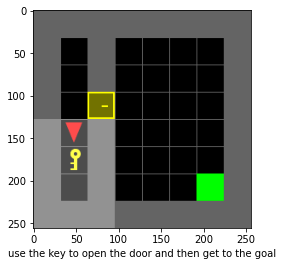

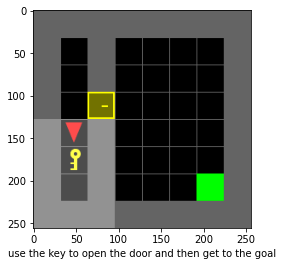

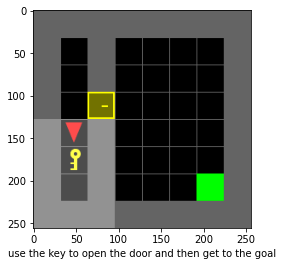

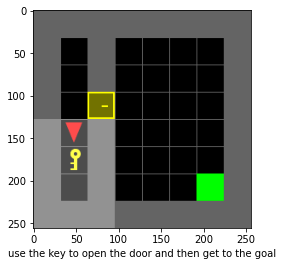

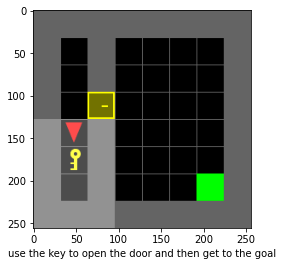

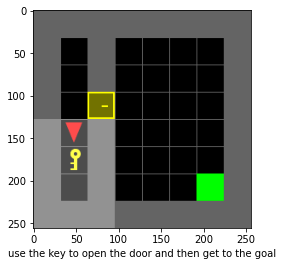

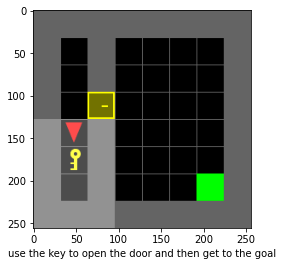

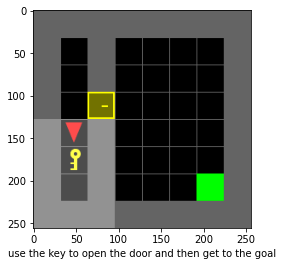

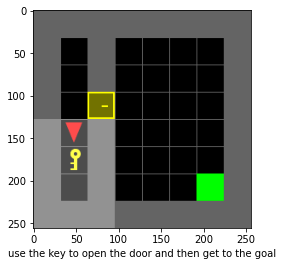

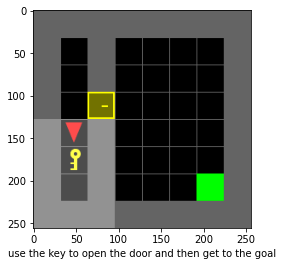

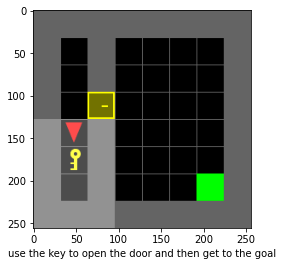

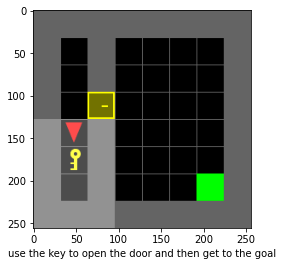

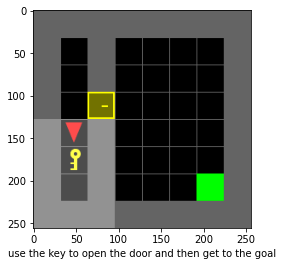

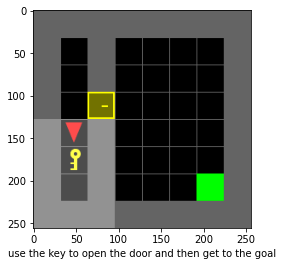

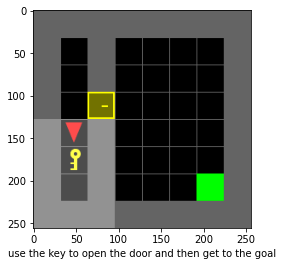

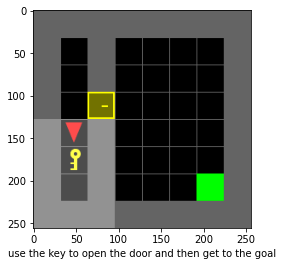

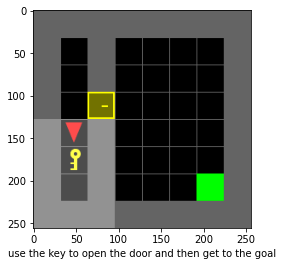

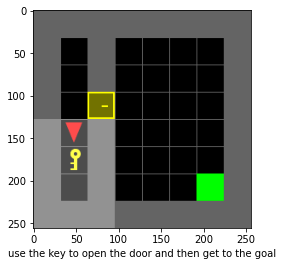

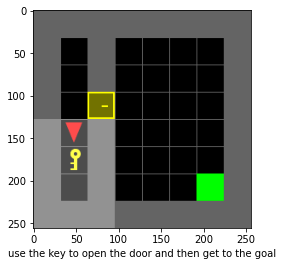

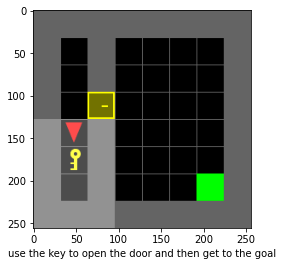

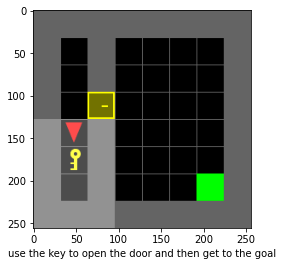

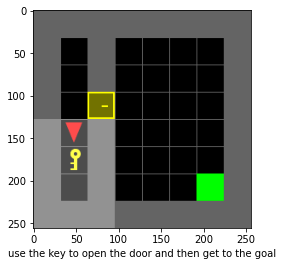

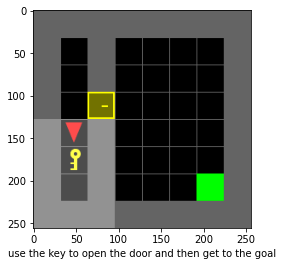

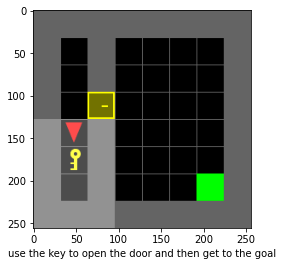

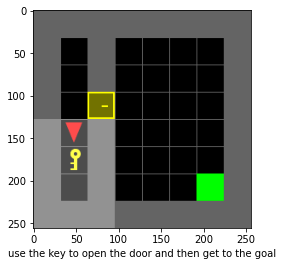

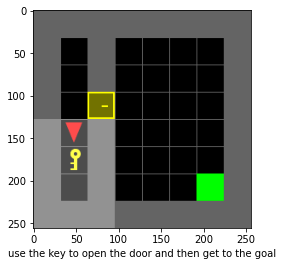

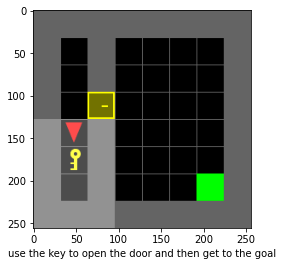

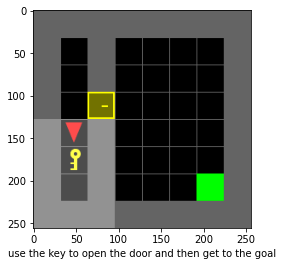

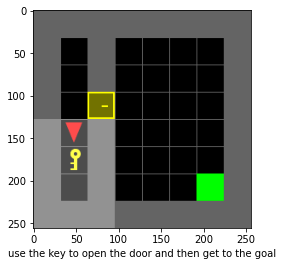

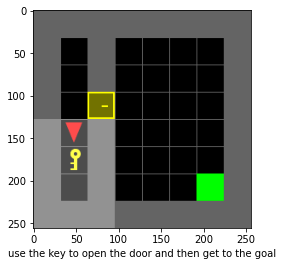

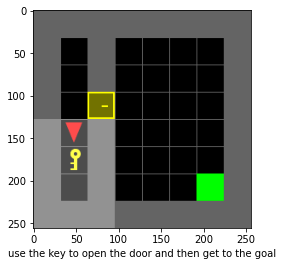

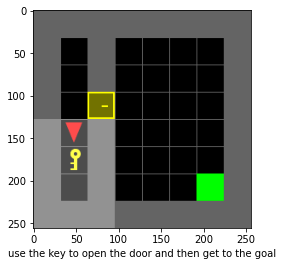

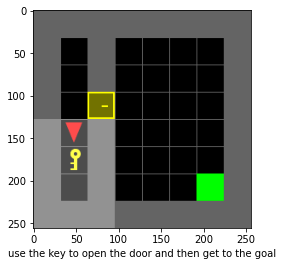

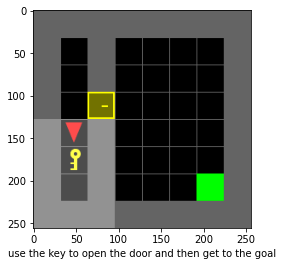

evaluation episode: 0 R: 0


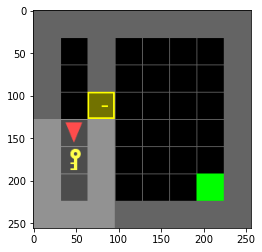

In [18]:
with agent_rec.eval_mode():
    for i in range(1):
        obs = env.reset()
        obs = obs.flatten()
        R = 0
        t = 0
        done = False
        while not done:
            # Uncomment to watch the behavior in a GUI window
            img = env.render()
            plt.imshow(img)
            action = agent_rec.act(obs)
            obs, r, done, _ = env.step(action)
            obs = obs.flatten()
            R += r
            t += 1
            reset = t == 200
            agent_rec.observe(obs, r, done, reset)
            if done or reset:
                break
        print('evaluation episode:', i, 'R:', R)